## 0. Import Libraries

In [193]:
import glob
import cartopy
import proplot as plot

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from shapely.geometry import mapping

import warnings
warnings.filterwarnings('ignore')

## 1. Define Parameters

In [29]:
# general data path
general_path = 'data'

# variable name
name_var = 'TOT_PREC'

# model and observation source names
name_model = 'cosmo'
name_obs = 'era5land'

# data aggregation type
type_agg = 'daysum_monmean'

# data time information
ref_interval = np.arange(1985, 2006) # including 1985 and 2006
ref_first = ref_interval[0]
ref_last = ref_interval[-1]

# reference data paths
common_path = fr'{general_path}/{name_var}'
path_model = fr'{common_path}/{name_model}/{name_model}_{type_agg}_{ref_first}_{ref_last}.nc'
path_obs = fr'{common_path}/{name_obs}/{name_obs}_{type_agg}_{ref_first}_{ref_last}.nc'

# shapefile paths
tr_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'

## 2. Open Data

### 2.1 Projection Data

In [3]:
# open data to fetch projection from
dt_proj = xr.open_dataset(r'data/lffd2100123118.nc')

### 2.2 Model Data

In [4]:
# open model data
dt_model = xr.open_dataset(path_model, engine='netcdf4')[name_var]

### 2.3 Observation Data

 (ERA5Land) This parameter is accumulated over a particular time period which depends on the data extracted. For the monthly averaged reanalysis and the monthly averaged ensemble members, the accumulation period is 1 day

In [5]:
# open observation data
dt_obs = xr.open_dataset(path_obs, engine='netcdf4')

# rename precipitation variable for observation
dt_obs = dt_obs.rename({'tp':name_var})

# take only variable
dt_obs = dt_obs[name_var]

# change unit from m to mm
dt_obs = dt_obs*1e3 # m to mm

# change unit attr
dt_obs = dt_obs.assign_attrs({'units':'kg m-2'})

In [6]:
dt_obs.attrs

{'units': 'kg m-2'}

## 3. Assign Projection

In [7]:
# define globe
globe = cartopy.crs.Globe(ellipse='sphere',
                          semimajor_axis=6370000,
                          semiminor_axis=6370000)

### 3.1 Model Data

In [8]:
# fetch model projection info
rotated_pole = dt_proj['rotated_pole']
pole_longitude = rotated_pole.attrs['grid_north_pole_longitude']
pole_latitude = rotated_pole.attrs['grid_north_pole_latitude']

In [9]:
# define model projection
proj_model = cartopy.crs.RotatedPole(pole_longitude=pole_longitude,
                               pole_latitude=pole_latitude,
                               globe=globe
                               )
proj_model.proj4_params

{'ellps': 'sphere',
 'a': 6370000,
 'b': 6370000,
 'proj': 'ob_tran',
 'o_proj': 'latlon',
 'o_lon_p': 0.0,
 'o_lat_p': 50.0,
 'lon_0': 33.0,
 'to_meter': 111177.4733520388}

In [10]:
# x and y dims
dt_x_dim_model = 'rlon'
dt_y_dim_model = 'rlat'

# write projection
dt_model = dt_model.rio.write_crs(proj_model)

# set spatial dims
dt_model = dt_model.rio.set_spatial_dims(x_dim=dt_x_dim_model,
                                         y_dim=dt_y_dim_model)

In [11]:
dt_model.rio.crs

CRS.from_wkt('GEOGCRS["unnamed",BASEGEOGCRS["unknown",DATUM["unknown",ELLIPSOID["unknown",6370000,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],DERIVINGCONVERSION["unknown",METHOD["PROJ ob_tran o_proj=latlon"],PARAMETER["o_lon_p",0,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["o_lat_p",50,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["lon_0",33,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CS[ellipsoidal,2],AXIS["longitude",east,ORDER[1],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],AXIS["latitude",north,ORDER[2],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]]')

### 3.2 Observation Data

In [12]:
# define observation projection
proj_obs = cartopy.crs.CRS('EPSG:4326',
                          )
proj_obs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
# x and y dims
dt_x_dim_obs = 'longitude'
dt_y_dim_obs = 'latitude'

# write projection
dt_obs = dt_obs.rio.write_crs(proj_obs)

# set spatial dims
dt_obs = dt_obs.rio.set_spatial_dims(x_dim=dt_x_dim_obs,
                                     y_dim=dt_y_dim_obs)

In [14]:
dt_obs.rio.crs

CRS.from_epsg(4326)

## 4. Match and Clip

### 4.1 Match Grids

In [15]:
def regrid_match(dt_to_match, dt_to_be_matched):
    
    """
    Regrid a file grid to a target grid. Requires input data array
    
    Return target file and regridded file
    
    """
    # reproject
    dt_to_be_matched = dt_to_be_matched.rio.reproject_match(dt_to_match)
    
    return dt_to_be_matched

In [86]:
dt_obs_regrid = regrid_match(dt_model, dt_obs,
                             )
dt_obs_regrid = dt_obs_regrid.rename({'x':'rlon',
                                      'y':'rlat'})

In [87]:
dt_obs_regrid = dt_obs_regrid.assign_coords(dict(lon=(['rlat', 'rlon'], dt_model.lon.values), 
                                                 lat=(['rlat', 'rlon'], dt_model.lat.values))
                                           )

### 4.2 Clip Data to Turkey

In [88]:
def clip_to_city(data, shapefile):
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [89]:
# open Turkey boundary
gdf_tr = gpd.read_file(tr_shape)

In [90]:
gdf_tr

,IL,Siralama,geometry
0,ADANA,1.0,"POLYGON Z ((36.31593 38.36382 0.00000, 36.3177..."
1,ADIYAMAN,2.0,"POLYGON Z ((39.25303 38.18194 0.00000, 39.2534..."
2,AFYONKARAHİSAR,3.0,"POLYGON Z ((31.14803 39.26252 0.00000, 31.1583..."
3,AĞRI,4.0,"POLYGON Z ((43.28712 40.01287 0.00000, 43.2913..."
4,AKSARAY,5.0,"POLYGON Z ((33.96452 39.03811 0.00000, 33.9645..."
...,...,...,...
76,UŞAK,77.0,"POLYGON Z ((29.75265 38.92391 0.00000, 29.7570..."
77,VAN,78.0,"POLYGON Z ((43.86299 39.35525 0.00000, 43.8663..."
78,YALOVA,79.0,"POLYGON Z ((29.55537 40.68848 0.00000, 29.5558..."
79,YOZGAT,80.0,"POLYGON Z ((35.38902 40.24671 0.00000, 35.3921..."


#### 4.2.1 Model Data

In [91]:
# clip to Turkey
dt_model_clip = clip_to_city(dt_model, gdf_tr)

#### 4.2.2 Observation Data

In [165]:
# clip to Turkey
dt_obs_regrid_clip = clip_to_city(dt_obs_regrid, gdf_tr)

# modify nodata
nodata_obs = dt_obs_regrid.rio.nodata
dt_obs_regrid_clip = dt_obs_regrid_clip.where(dt_obs_regrid_clip != nodata_obs)

# make rlon and rlat exactly same to model
dt_obs_regrid_clip['rlon'] = dt_model_clip['rlon']
dt_obs_regrid_clip['rlat'] = dt_model_clip['rlat']

## 5.Calculate Climatologies

### 5.1 Monthly Mean

#### 5.1.1 Model Data

In [167]:
dt_model_monmean_clim = dt_model_clip.groupby('time.month').mean() # already mm (kgm**s-2)

#### 5.1.2 Observation Data

In [168]:
dt_obs_monmean_clim = dt_obs_regrid_clip.groupby('time.month').mean()

### 5.2 Seasonally Mean

#### 5.2.1 Model Data

In [169]:
dt_model_seasonmean_clim = dt_model_clip.groupby('time.season').mean() # already mm (kgm**s-2)

#### 5.2.2 Observation Data

In [170]:
dt_obs_seasonmean_clim = dt_obs_regrid_clip.groupby('time.season').mean()

### 5.3 Annual Mean

#### 5.3.1 Model Data

In [171]:
dt_model_annualmean_clim = dt_model_clip.groupby('time.year').mean() # already mm (kgm**s-2)

#### 5.3.2 Observation Data

In [172]:
dt_obs_annualmean_clim = dt_obs_regrid_clip.groupby('time.year').mean()

## 6. Quick Look Over Data

### 6.1 Model Data

#### 6.1.1 Monthly Mean

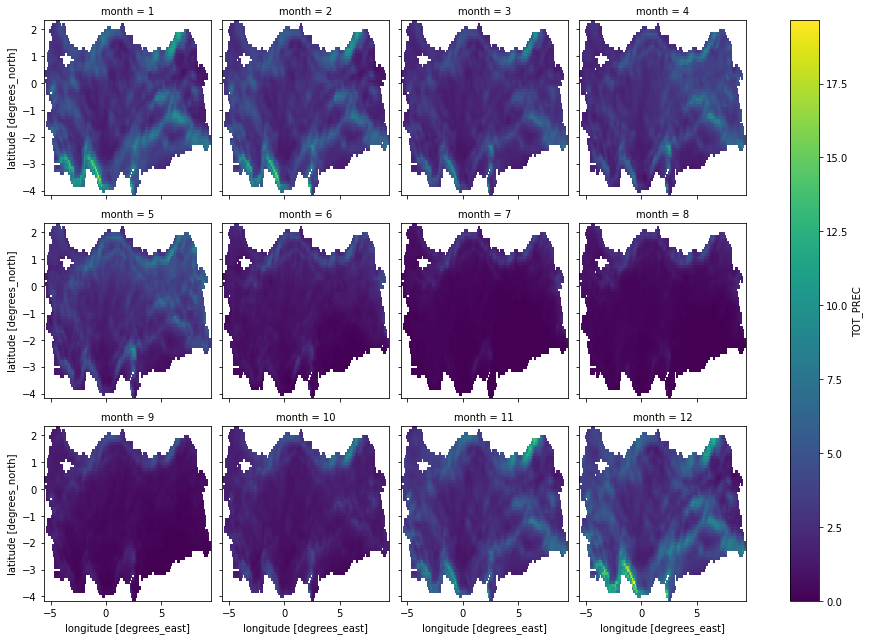

In [173]:
dt_model_monmean_clim.plot(col='month',
                                   col_wrap=4)

#### 6.1.2 Seasonally Mean

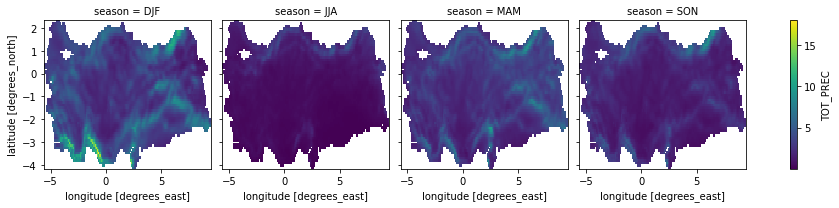

In [174]:
dt_model_seasonmean_clim.plot(col='season',
                                      col_wrap=4)

#### 6.1.3 Annual Mean

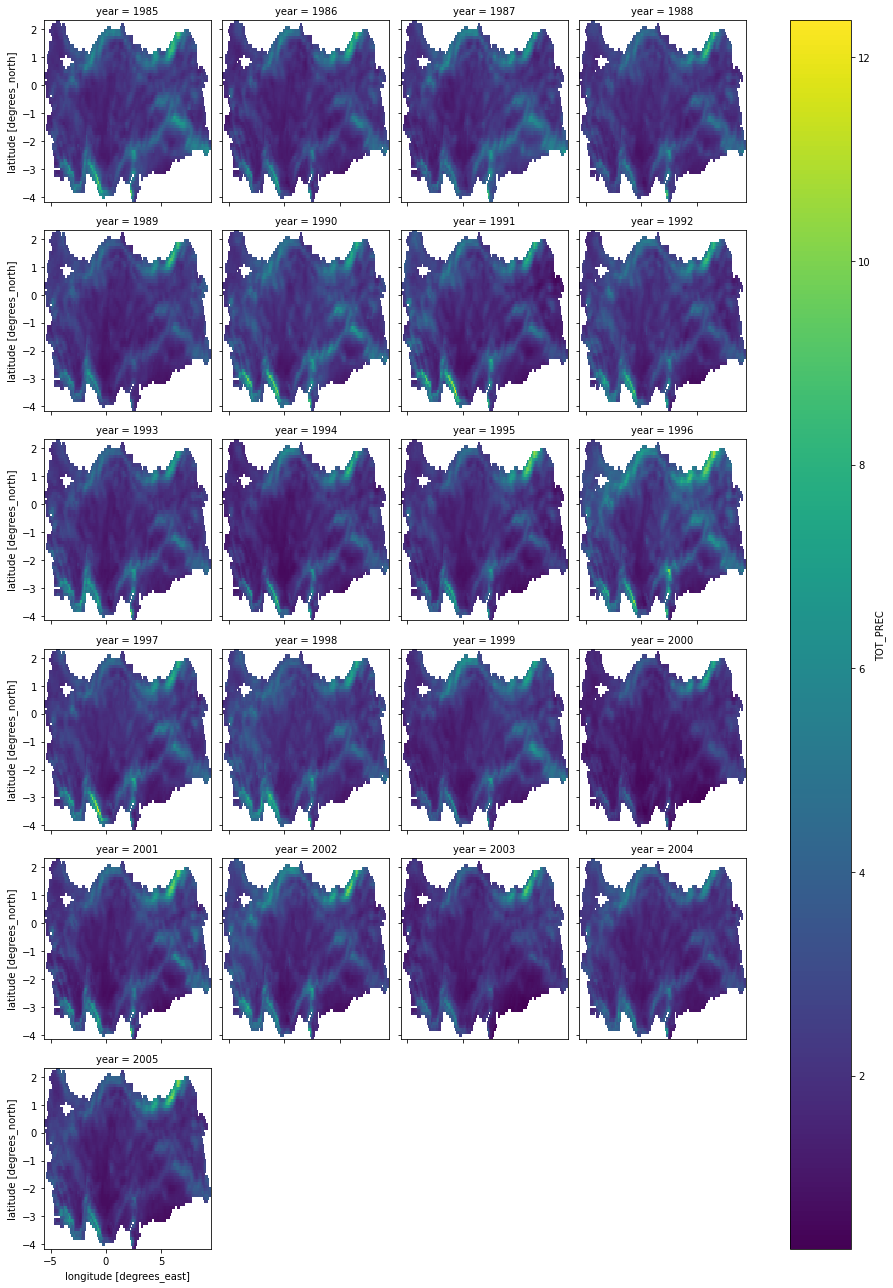

In [175]:
dt_model_annualmean_clim.plot(col='year',
                                      col_wrap=4)

### 6.2 Observation Data

#### 6.2.1 Monthly Mean

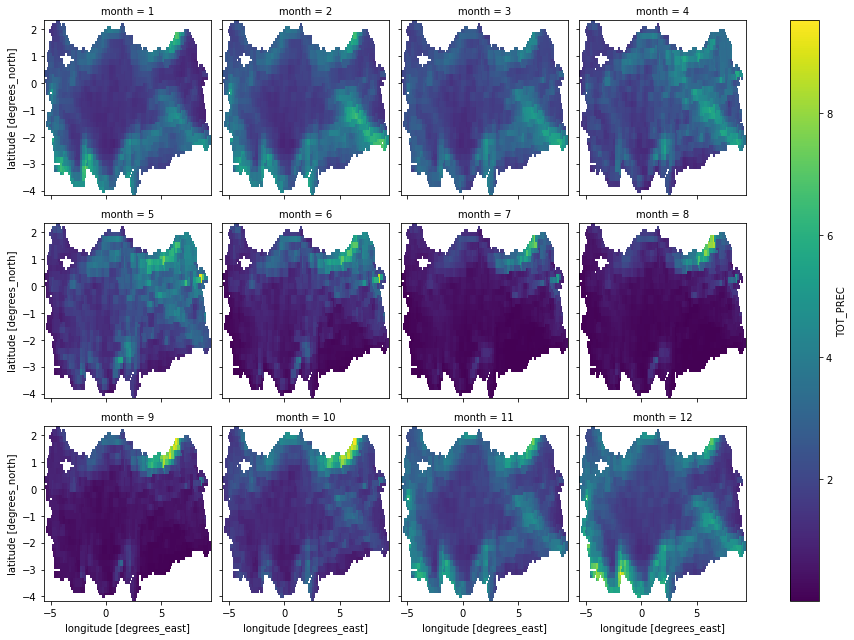

In [176]:
dt_obs_monmean_clim.plot(col='month',
                                   col_wrap=4)

#### 6.2.2 Seasonally Mean

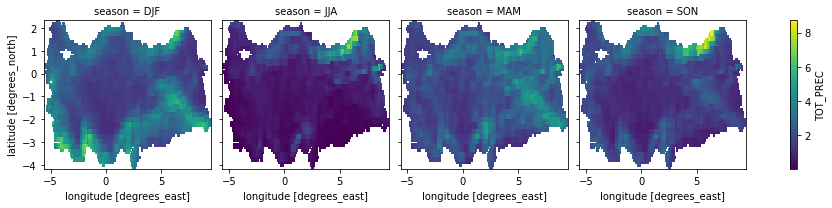

In [177]:
dt_obs_seasonmean_clim.plot(col='season',
                                      col_wrap=4)

#### 6.2.3 Annual Mean

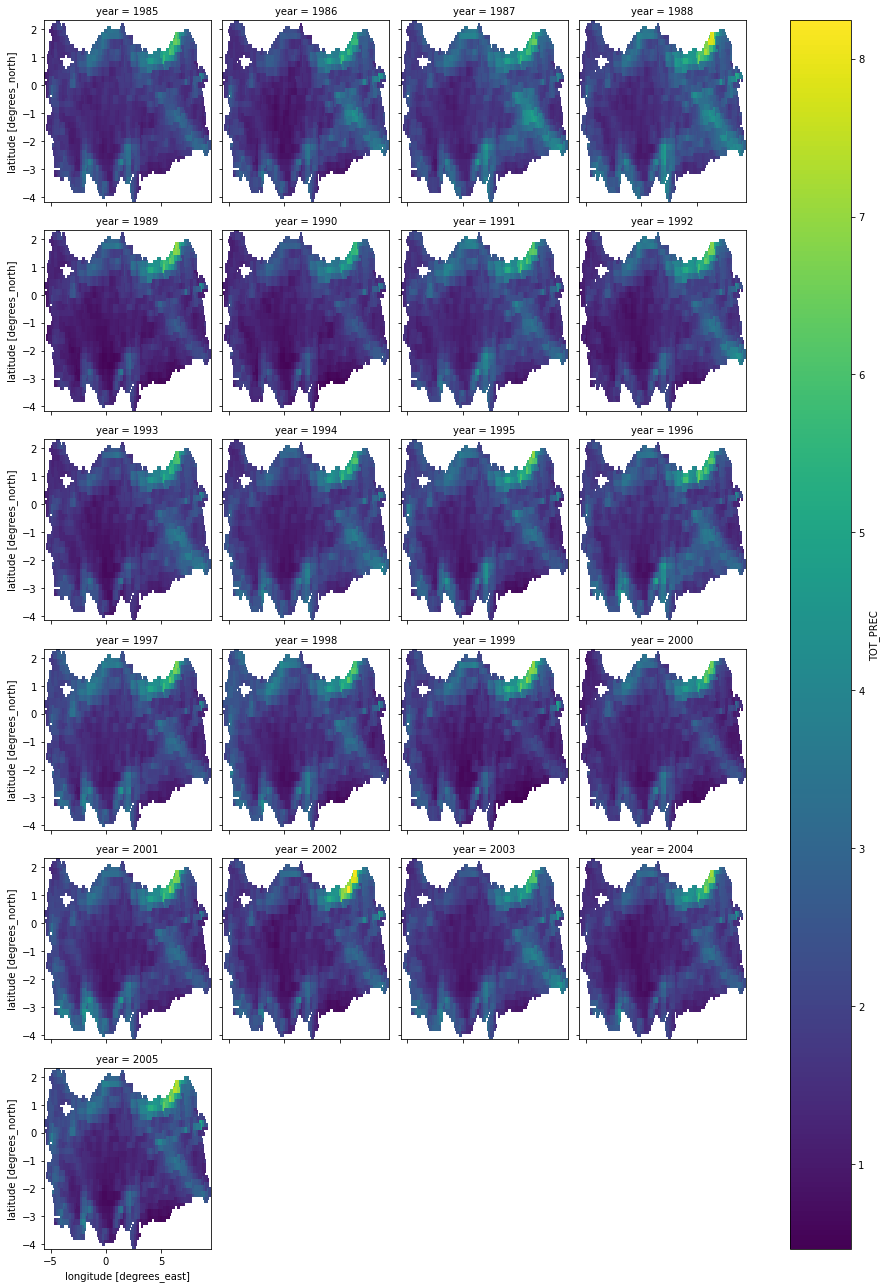

In [178]:
dt_obs_annualmean_clim.plot(col='year',
                                      col_wrap=4)

## 7. Difference Graphics

In [208]:
cmap = plot.Colormap('BrBG', cut=0.01)

### 7.1 Monthly Mean

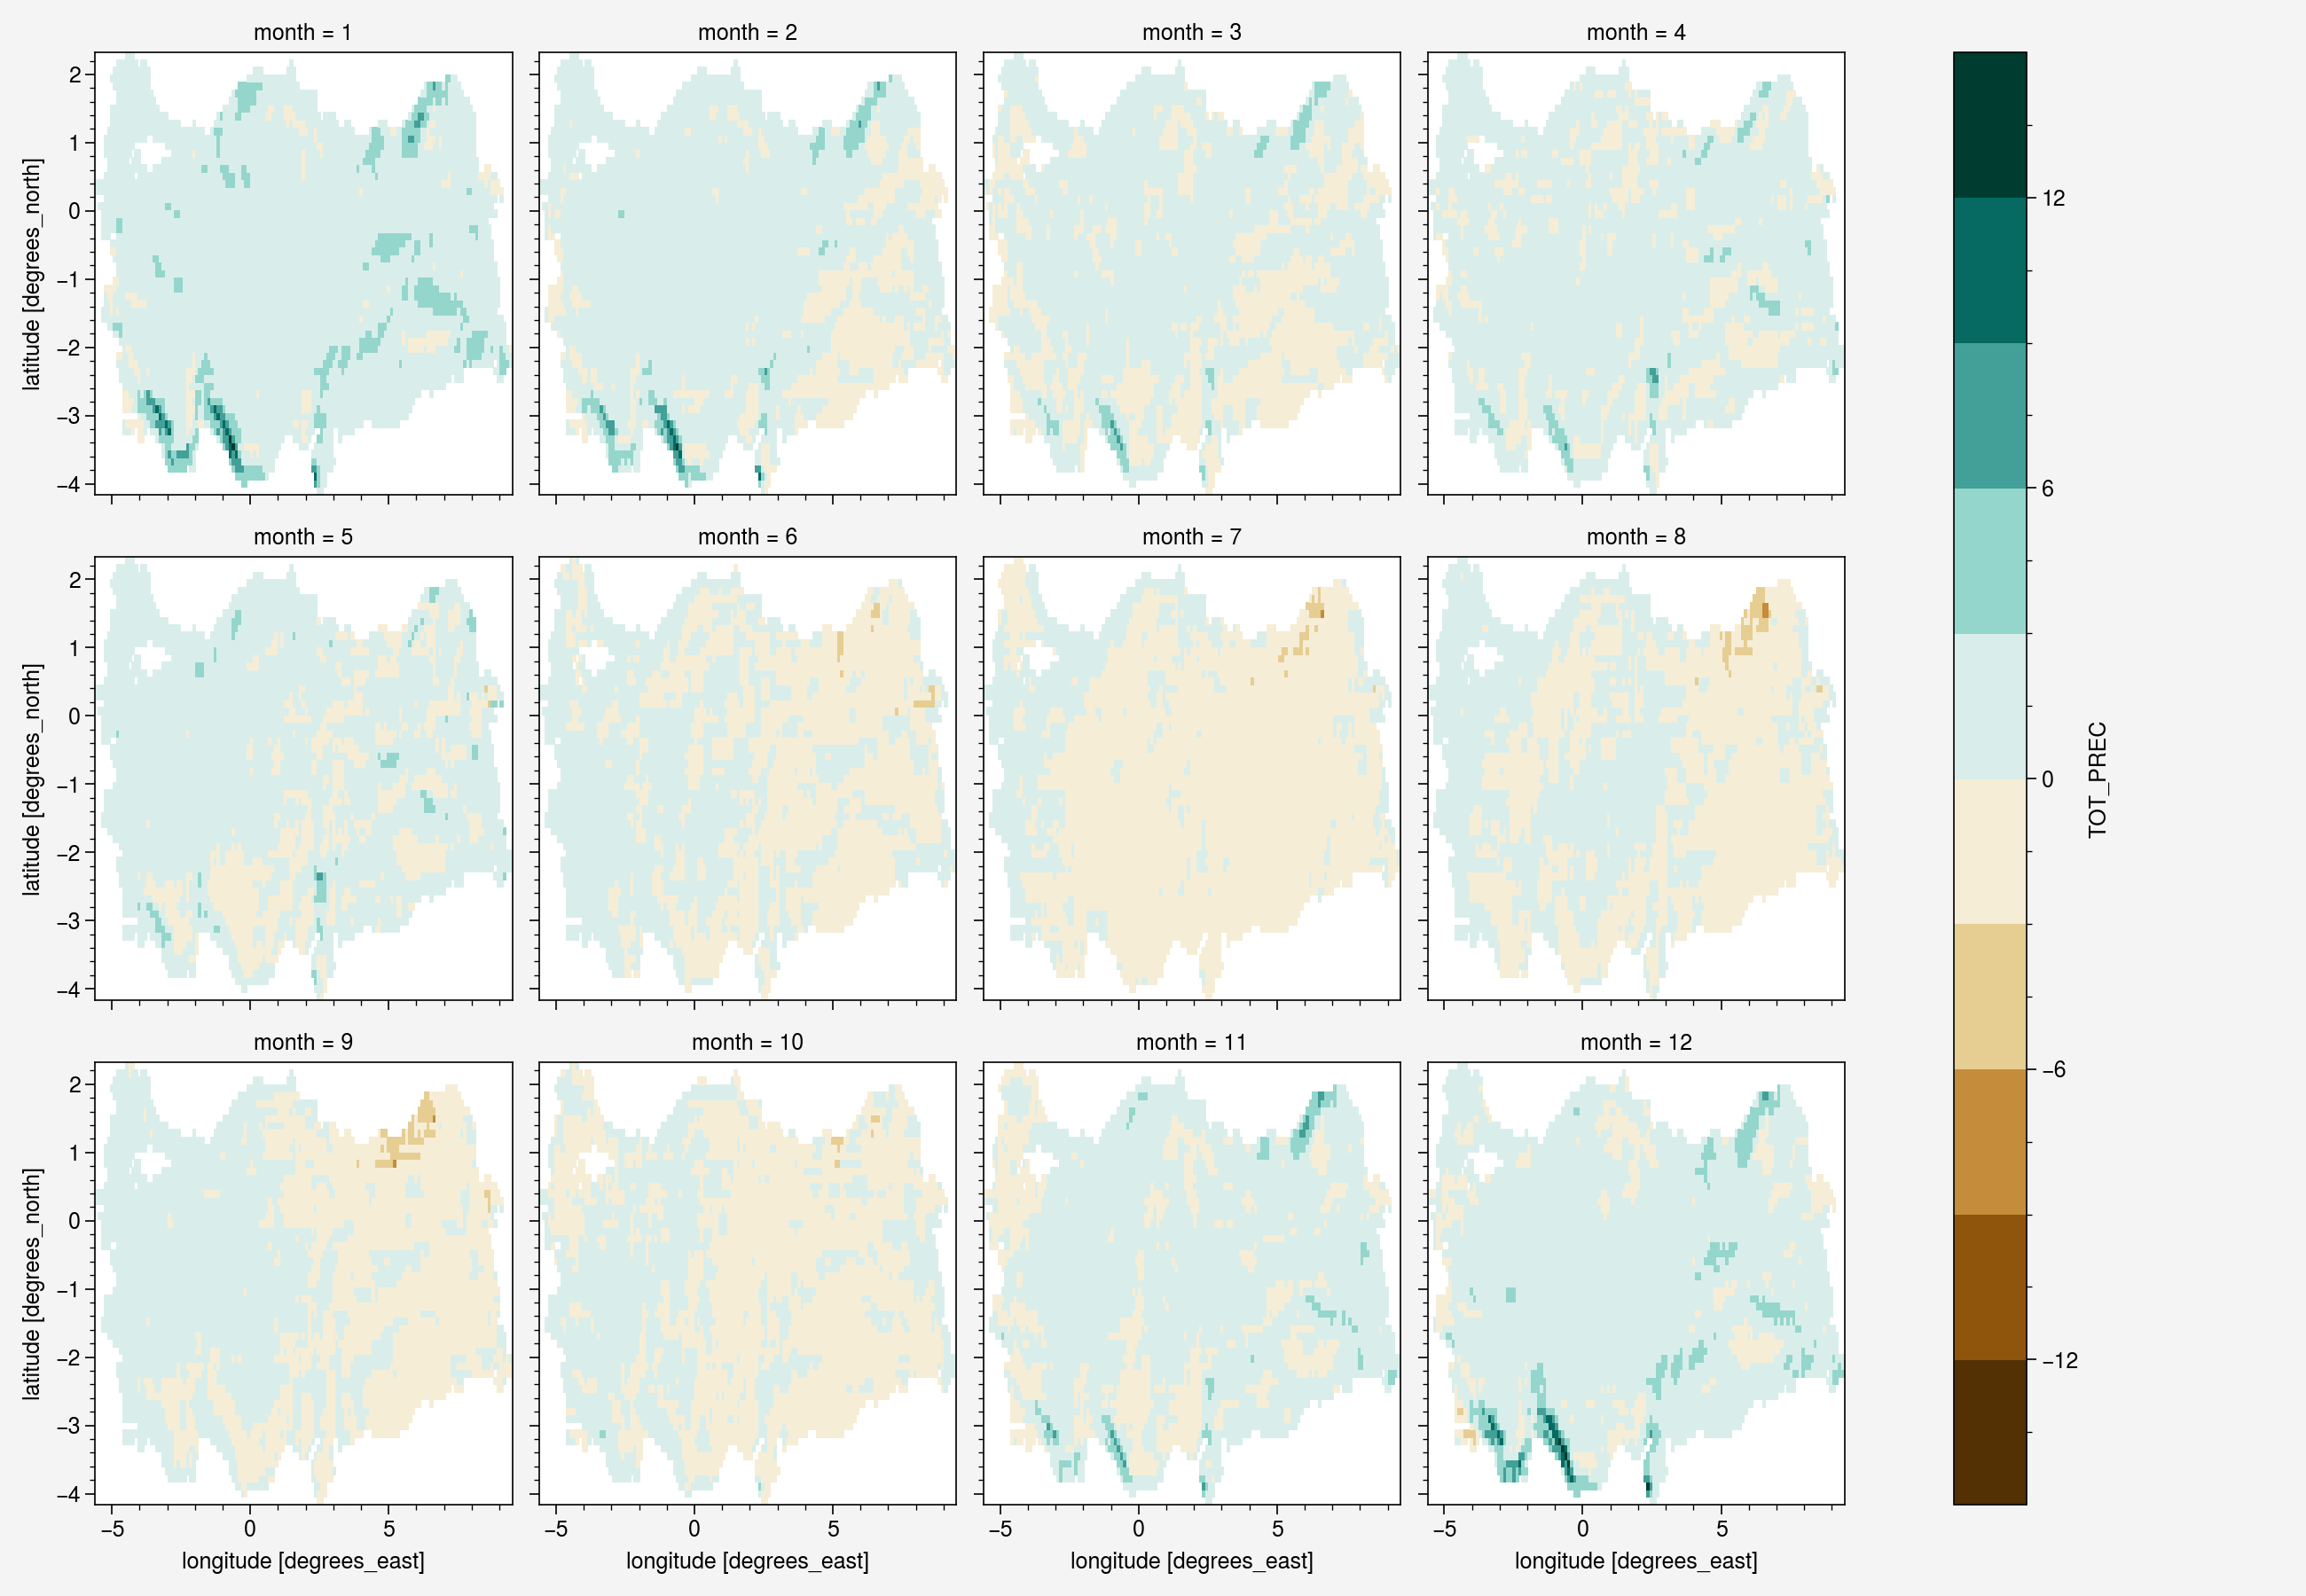

In [212]:
(dt_model_monmean_clim - dt_obs_monmean_clim).plot(col='month',
                                                   col_wrap=4,
                                                   vmin=-15,
                                                   vmax=15,
                                                   cmap=cmap,
                                                   levels=np.arange(-15,15.01,3)
                                                   )

### 7.2 Seasonally Mean

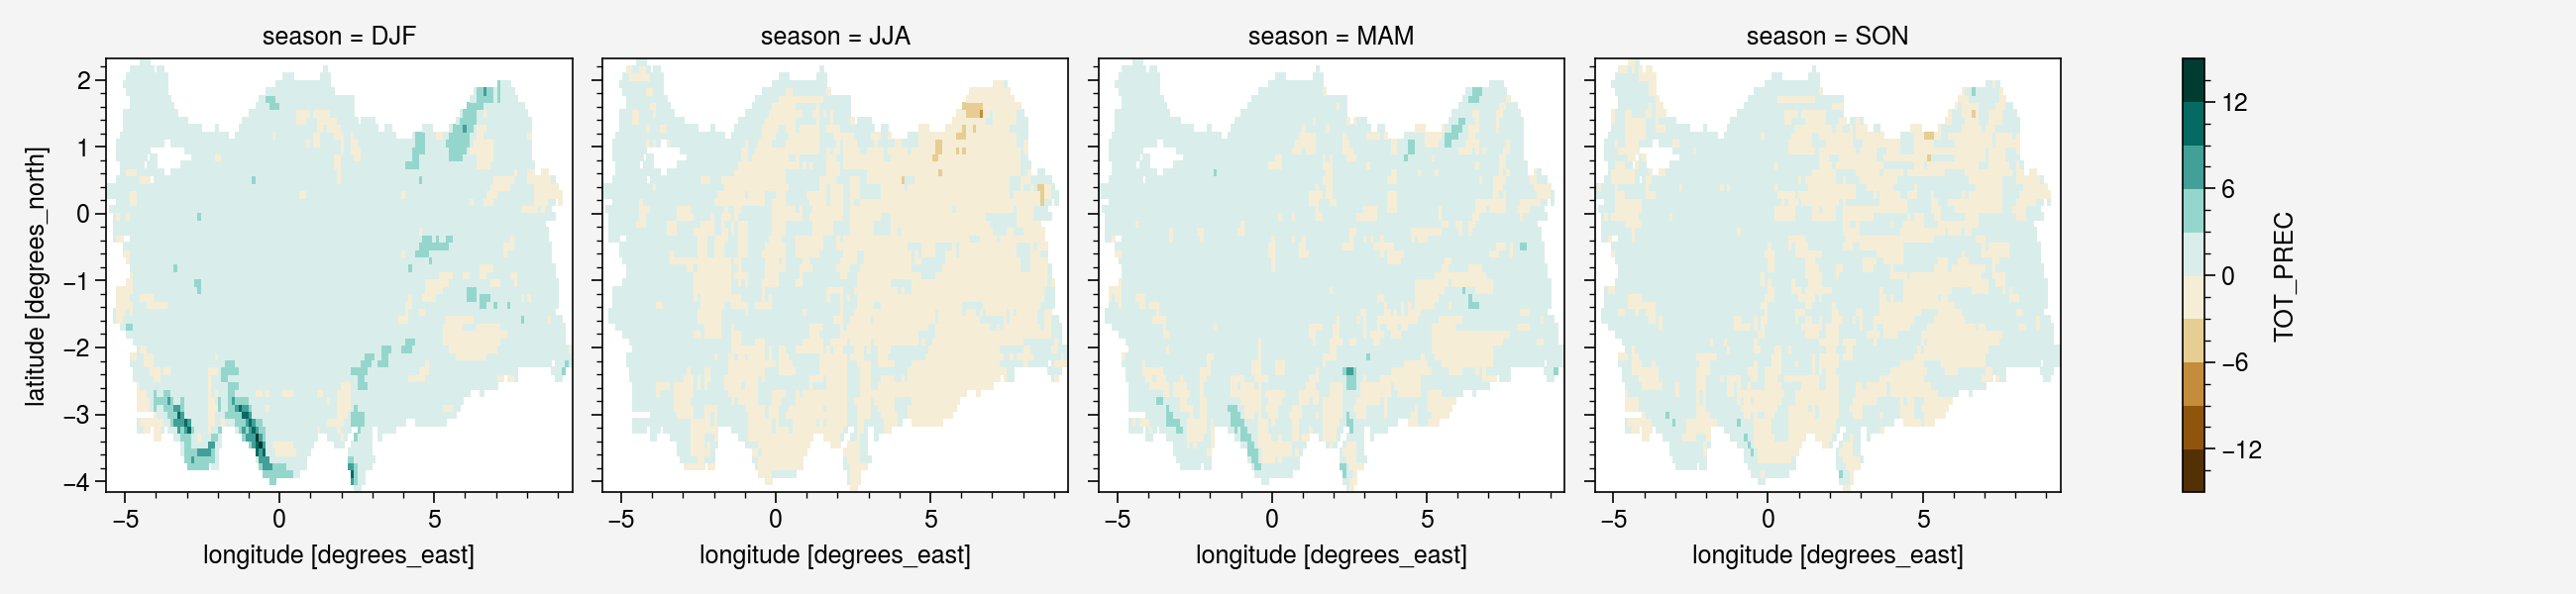

In [213]:
(dt_model_seasonmean_clim - dt_obs_seasonmean_clim).plot(col='season',
                                                       col_wrap=4,
                                                       vmin=-15,
                                                       vmax=15,
                                                       cmap=cmap,
                                                       levels=np.arange(-15,15.01,3)
                                                        )

### 7.3 Annual Mean

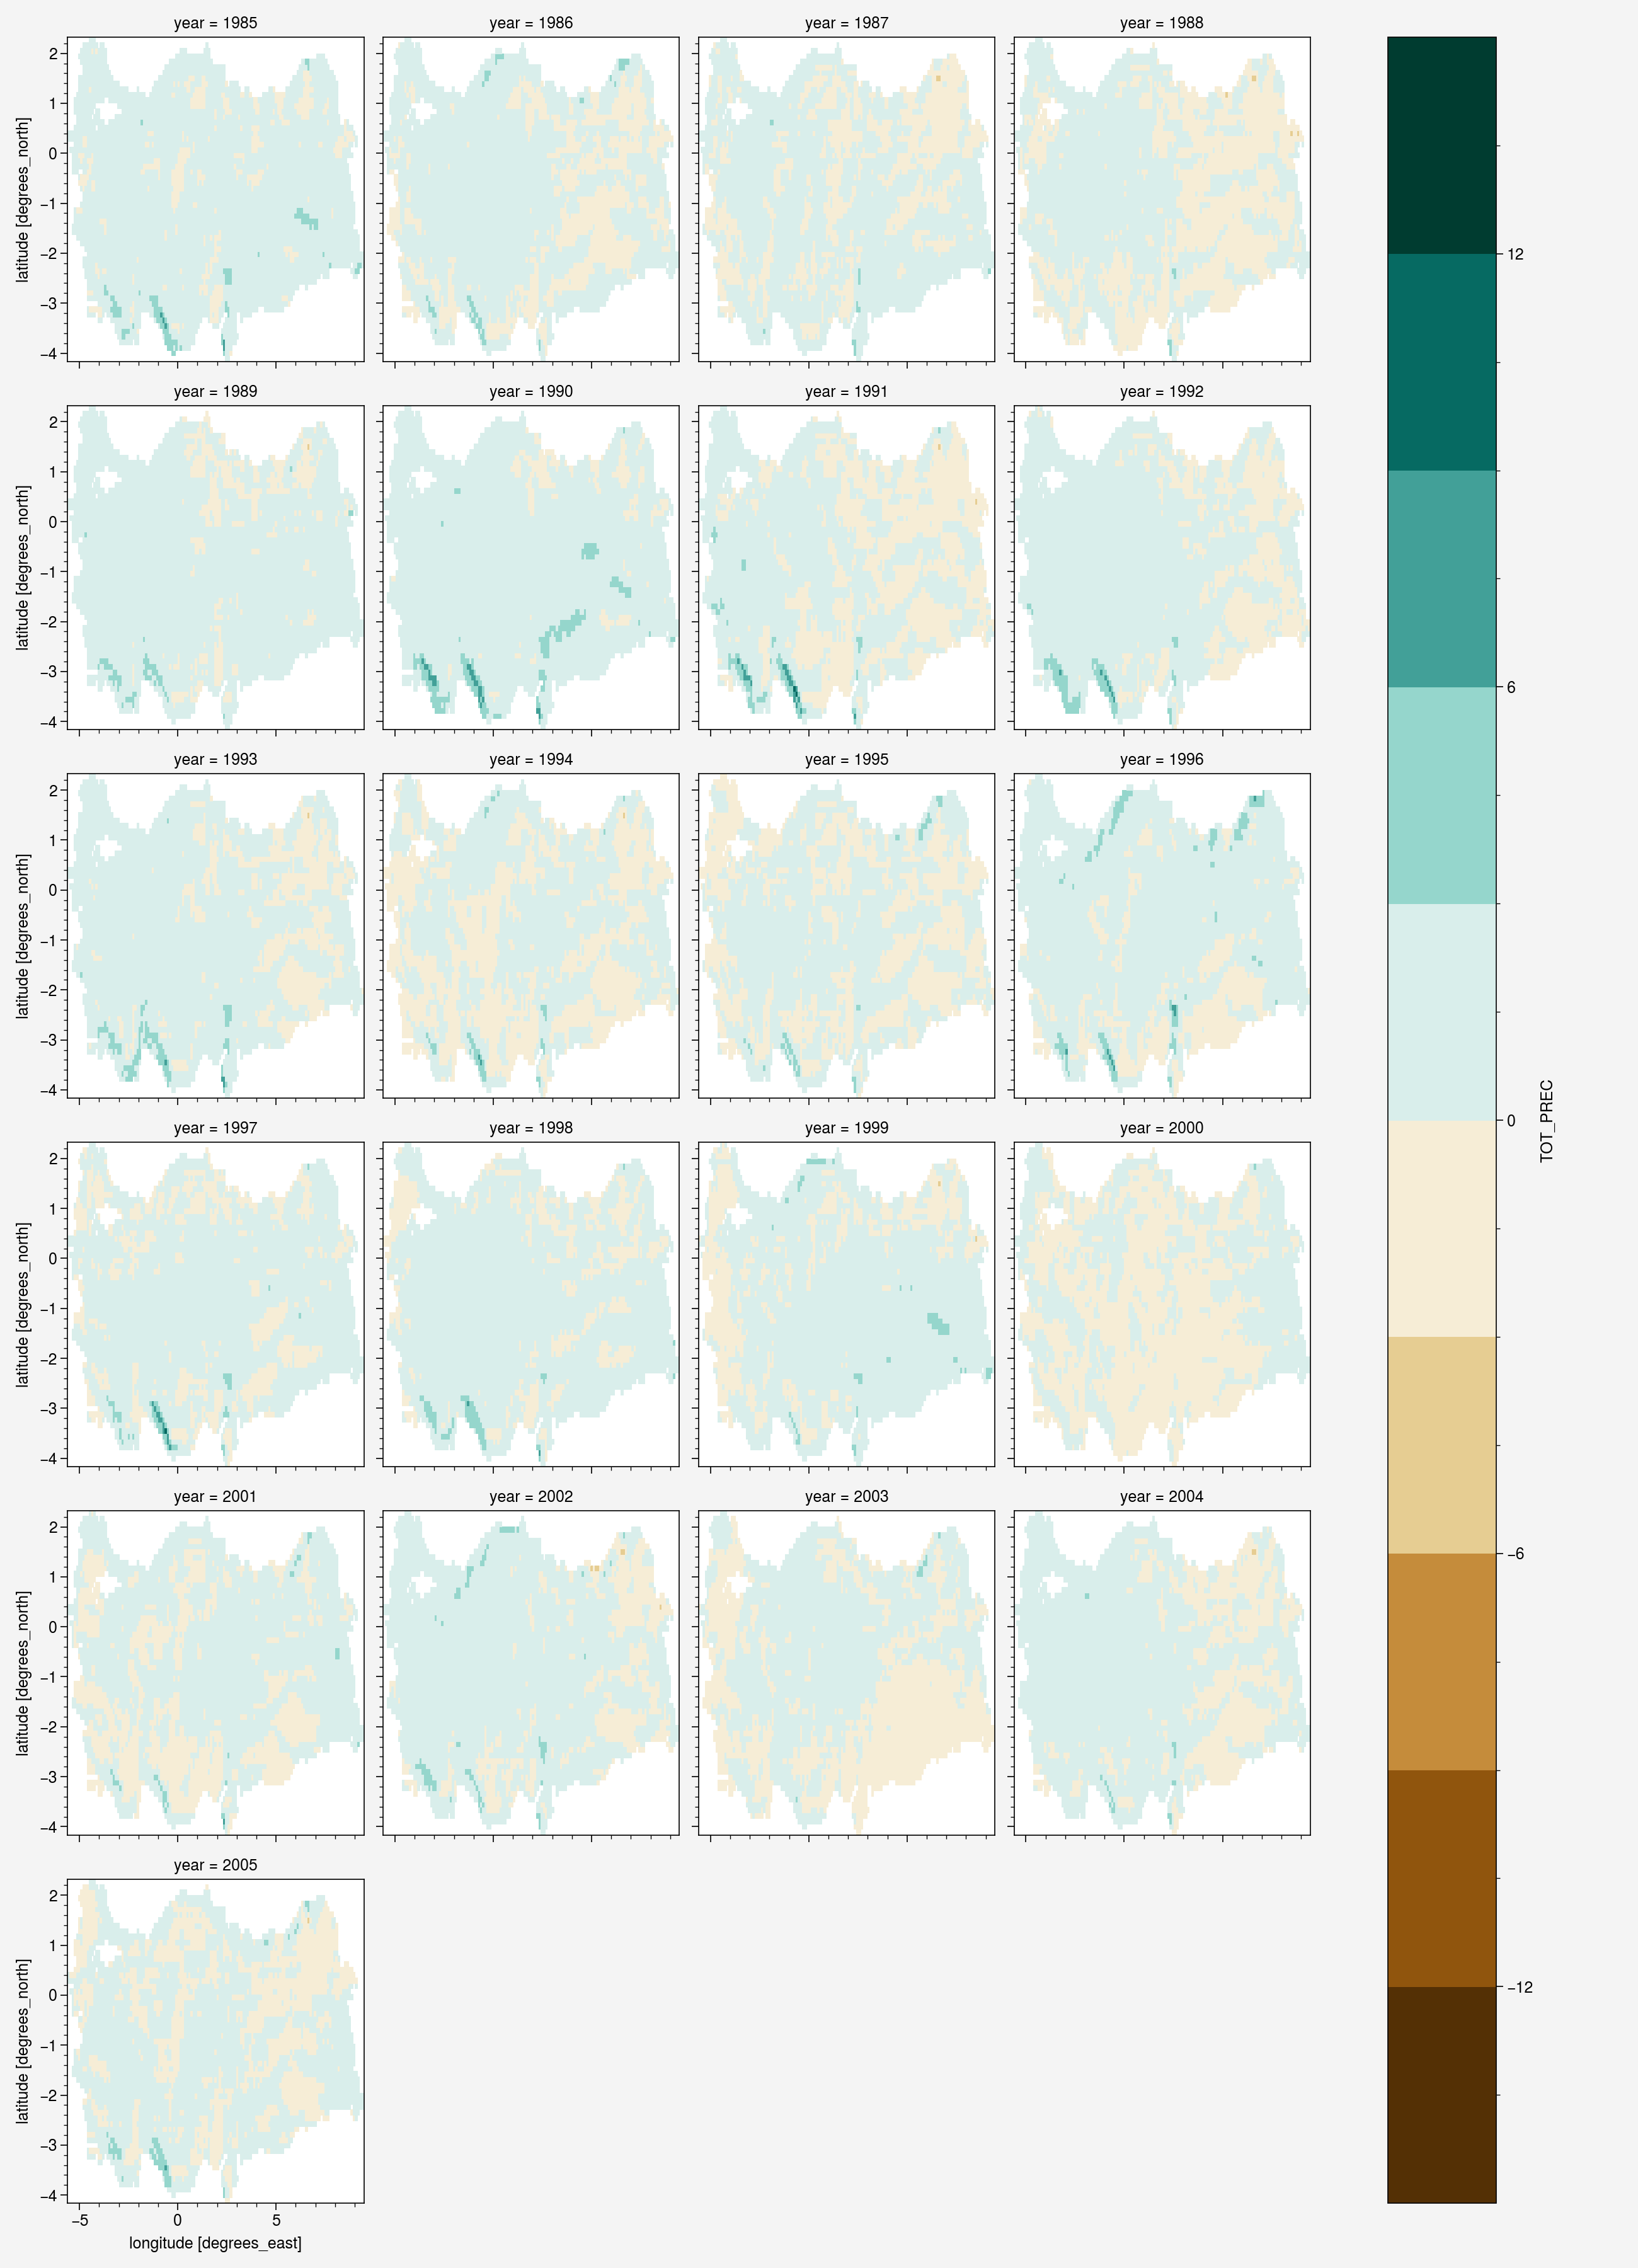

In [214]:
(dt_model_annualmean_clim - dt_obs_annualmean_clim).plot(col='year',
                                                       col_wrap=4,
                                                       vmin=-15,
                                                       vmax=15,
                                                       cmap=cmap,
                                                       levels=np.arange(-15,15.01,3)
                                                        )